In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time
import copy

print(f"PyTorch version: {torch.__version__}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class PositionalEncoding(nn.Module):
    """
    Implements the positional encoding as described in the paper.
    Uses sine and cosine functions of different frequencies.
    """
    def __init__(self, d_model, max_seq_length=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)

        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension [1, max_seq_length, d_model]
        pe = pe.unsqueeze(0)

        # Register buffer (persistent state)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)



def scaled_dot_product_attention(query, key, value, mask=None, dropout=None):
    """
    Computes scaled dot product attention as described in the paper.

    Args:
        query: Tensor, shape [..., seq_len_q, depth]
        key: Tensor, shape [..., seq_len_k, depth]
        value: Tensor, shape [..., seq_len_k, depth_v]
        mask: Tensor that masks out certain positions, shape [..., seq_len_q, seq_len_k]
        dropout: Dropout layer

    Returns:
        output: Weighted sum
        attention_weights: Attention weights
    """
    # Calculate Q·K^T
    matmul_qk = torch.matmul(query, key.transpose(-2, -1))

    # Scale matmul_qk
    d_k = query.size(-1)
    scaled_attention_logits = matmul_qk / math.sqrt(d_k)

    # Apply mask if provided
    if mask is not None:
        scaled_attention_logits = scaled_attention_logits.masked_fill(mask == 0, -1e9)

    # Apply softmax to get attention weights
    attention_weights = F.softmax(scaled_attention_logits, dim=-1)

    # Apply dropout if provided
    if dropout is not None:
        attention_weights = dropout(attention_weights)

    # Calculate weighted sum
    output = torch.matmul(attention_weights, value)

    return output, attention_weights



class MultiHeadAttention(nn.Module):
    """
    Multi-head attention as described in the paper.
    Allows the model to jointly attend to information from different positions.
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Linear projections
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        # Output projection
        self.wo = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(p=dropout)

    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, depth)
        and transpose the result to (batch_size, num_heads, seq_len, depth)
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Linear projections and split heads
        query = self.split_heads(self.wq(query), batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        key = self.split_heads(self.wk(key), batch_size)      # (batch_size, num_heads, seq_len_k, depth)
        value = self.split_heads(self.wv(value), batch_size)  # (batch_size, num_heads, seq_len_k, depth)

        # Scaled dot-product attention
        scaled_attention, attention_weights = scaled_dot_product_attention(
            query, key, value, mask, self.dropout
        )

        # Reshape back to (batch_size, seq_len_q, d_model)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # Final projection
        output = self.wo(concat_attention)

        return output, attention_weights



class PositionwiseFeedForward(nn.Module):
    """
    Simple feed-forward network applied to each position separately and identically.
    Consists of two linear transformations with a ReLU activation in between.
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
        """
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x



class LayerNormalization(nn.Module):
    """
    Layer normalization module.
    Normalizes the inputs across feature dimension.
    """
    def __init__(self, features, eps=1e-6):
        super(LayerNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta



class EncoderLayer(nn.Module):
    """
    Single layer of the encoder.
    Consists of multi-head self-attention and position-wise feed-forward networks.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()

        # Multi-head attention
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)

        # Feed-forward network
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)

        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Dropout
        self.dropout1 = nn.Dropout(p=dropout)
        self.dropout2 = nn.Dropout(p=dropout)

    def forward(self, x, mask=None):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
            mask: Tensor, shape [batch_size, 1, 1, seq_len]
        """
        # Multi-head attention with residual connection and layer normalization
        attn_output, _ = self.self_attn(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)

        # Feed-forward with residual connection and layer normalization
        ff_output = self.feed_forward(out1)
        ff_output = self.dropout2(ff_output)
        out2 = self.norm2(out1 + ff_output)

        return out2


class DecoderLayer(nn.Module):
    """
    Single layer of the decoder.
    Consists of masked multi-head self-attention, multi-head attention over encoder output,
    and position-wise feed-forward networks.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # Multi-head attention (self-attention)
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)

        # Multi-head attention (encoder-decoder attention)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads, dropout)

        # Feed-forward network
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)

        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        # Dropout
        self.dropout1 = nn.Dropout(p=dropout)
        self.dropout2 = nn.Dropout(p=dropout)
        self.dropout3 = nn.Dropout(p=dropout)

    def forward(self, x, enc_output, look_ahead_mask=None, padding_mask=None):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
            enc_output: Tensor, shape [batch_size, enc_seq_len, d_model]
            look_ahead_mask: Tensor to mask future positions, shape [batch_size, 1, seq_len, seq_len]
            padding_mask: Tensor to mask padding tokens, shape [batch_size, 1, 1, enc_seq_len]
        """
        # Masked multi-head self-attention with residual connection and layer normalization
        attn1_output, _ = self.self_attn(x, x, x, look_ahead_mask)
        attn1_output = self.dropout1(attn1_output)
        out1 = self.norm1(x + attn1_output)

        # Multi-head attention over encoder output with residual connection and layer normalization
        attn2_output, _ = self.enc_dec_attn(out1, enc_output, enc_output, padding_mask)
        attn2_output = self.dropout2(attn2_output)
        out2 = self.norm2(out1 + attn2_output)

        # Feed-forward with residual connection and layer normalization
        ff_output = self.feed_forward(out2)
        ff_output = self.dropout3(ff_output)
        out3 = self.norm3(out2 + ff_output)

        return out3



class Encoder(nn.Module):
    """
    Full encoder stack consisting of N identical layers.
    """
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size,
                 max_seq_length=5000, dropout=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(input_vocab_size, d_model)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length, dropout)

        # Encoder layers
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len]
            mask: Tensor to mask padding tokens, shape [batch_size, 1, 1, seq_len]
        """
        seq_len = x.size(1)

        # Embedding and scaling
        x = self.embedding(x) * math.sqrt(self.d_model)

        # Add positional encoding
        x = self.pos_encoding(x)

        # Process through encoder layers
        for layer in self.layers:
            x = layer(x, mask)

        return x  # (batch_size, seq_len, d_model)


class Decoder(nn.Module):
    """
    Full decoder stack consisting of N identical layers.
    """
    def __init__(self, num_layers, d_model, num_heads, d_ff, target_vocab_size,
                 max_seq_length=5000, dropout=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(target_vocab_size, d_model)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length, dropout)

        # Decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_output, look_ahead_mask=None, padding_mask=None):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len]
            enc_output: Encoder output, shape [batch_size, enc_seq_len, d_model]
            look_ahead_mask: Tensor to mask future positions, shape [batch_size, 1, seq_len, seq_len]
            padding_mask: Tensor to mask padding tokens, shape [batch_size, 1, 1, enc_seq_len]
        """
        seq_len = x.size(1)

        # Embedding and scaling
        x = self.embedding(x) * math.sqrt(self.d_model)

        # Add positional encoding
        x = self.pos_encoding(x)

        # Process through decoder layers
        for layer in self.layers:
            x = layer(x, enc_output, look_ahead_mask, padding_mask)

        return x  # (batch_size, seq_len, d_model)




PyTorch version: 2.0.0+cu117
Using device: cpu


In [2]:

class Transformer(nn.Module):
    """
    Full transformer model as described in "Attention Is All You Need".
    Consists of an encoder and a decoder.
    """
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size,
                 target_vocab_size, max_seq_length=5000, dropout=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff,
                               input_vocab_size, max_seq_length, dropout)

        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff,
                               target_vocab_size, max_seq_length, dropout)

        self.final_layer = nn.Linear(d_model, target_vocab_size)

    def forward(self, inp, tar, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
        """
        Args:
            inp: Encoder input, shape [batch_size, inp_seq_len]
            tar: Decoder input, shape [batch_size, tar_seq_len]
            enc_padding_mask: Mask for encoder, shape [batch_size, 1, 1, inp_seq_len]
            look_ahead_mask: Mask for decoder self-attention, shape [batch_size, 1, tar_seq_len, tar_seq_len]
            dec_padding_mask: Mask for decoder attention over encoder output, shape [batch_size, 1, 1, inp_seq_len]
        """
        # Encoder
        enc_output = self.encoder(inp, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # Decoder
        dec_output = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)  # (batch_size, tar_seq_len, d_model)

        # Final linear layer
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output


def create_padding_mask(seq):
    """
    Creates mask for padding tokens (value 0).

    Args:
        seq: Tensor of shape [batch_size, seq_len]

    Returns:
        mask: Tensor of shape [batch_size, 1, 1, seq_len]
    """
    # Create mask for padding tokens (value 0)
    mask = (seq == 0).float()

    # Add dimensions for multi-head attention
    return mask.unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_len)


def create_look_ahead_mask(size):
    """
    Creates mask to prevent attention to future tokens.

    Args:
        size: Integer, size of the mask

    Returns:
        mask: Tensor of shape [size, size] with 1s in the lower triangular part
    """
    # Create a lower triangular matrix with 1s and 0s on the upper triangular
    mask = torch.triu(torch.ones(size, size), diagonal=1).float()

    # Invert the mask, setting 1s to 0s and 0s to 1s
    return 1 - mask


def create_masks(inp, tar):
    """
    Creates all the masks needed for transformer training.

    Args:
        inp: Input tensor, shape [batch_size, inp_seq_len]
        tar: Target tensor, shape [batch_size, tar_seq_len]

    Returns:
        enc_padding_mask: Mask for encoder padding
        combined_mask: Combined look ahead and padding mask for decoder
        dec_padding_mask: Padding mask for decoder
    """
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Decoder padding mask (for attention over encoder output)
    dec_padding_mask = create_padding_mask(inp)

    # Look ahead mask for decoder self-attention
    look_ahead_mask = create_look_ahead_mask(tar.size(1))
    dec_target_padding_mask = create_padding_mask(tar)

    # Combine the masks (using broadcasting)
    combined_mask = torch.max(
        dec_target_padding_mask,
        look_ahead_mask.unsqueeze(0).to(tar.device)
    )

    return enc_padding_mask, combined_mask, dec_padding_mask


Epoch 1/10, Batch 10/32, Loss: 4.7749
Epoch 1/10, Batch 20/32, Loss: 4.7573
Epoch 1/10, Batch 30/32, Loss: 4.7760
Epoch 1/10, Average Loss: 4.7741
Epoch 2/10, Batch 10/32, Loss: 4.7618
Epoch 2/10, Batch 20/32, Loss: 4.7221
Epoch 2/10, Batch 30/32, Loss: 4.7017
Epoch 2/10, Average Loss: 4.7355
Epoch 3/10, Batch 10/32, Loss: 4.6829
Epoch 3/10, Batch 20/32, Loss: 4.6194
Epoch 3/10, Batch 30/32, Loss: 4.6635
Epoch 3/10, Average Loss: 4.6791
Epoch 4/10, Batch 10/32, Loss: 4.6393
Epoch 4/10, Batch 20/32, Loss: 4.5930
Epoch 4/10, Batch 30/32, Loss: 4.6068
Epoch 4/10, Average Loss: 4.6221
Epoch 5/10, Batch 10/32, Loss: 4.5653
Epoch 5/10, Batch 20/32, Loss: 4.5630
Epoch 5/10, Batch 30/32, Loss: 4.5717
Epoch 5/10, Average Loss: 4.5779
Epoch 6/10, Batch 10/32, Loss: 4.5128
Epoch 6/10, Batch 20/32, Loss: 4.5313
Epoch 6/10, Batch 30/32, Loss: 4.4995
Epoch 6/10, Average Loss: 4.5199
Epoch 7/10, Batch 10/32, Loss: 4.4308
Epoch 7/10, Batch 20/32, Loss: 4.4241
Epoch 7/10, Batch 30/32, Loss: 4.3776
Epoc

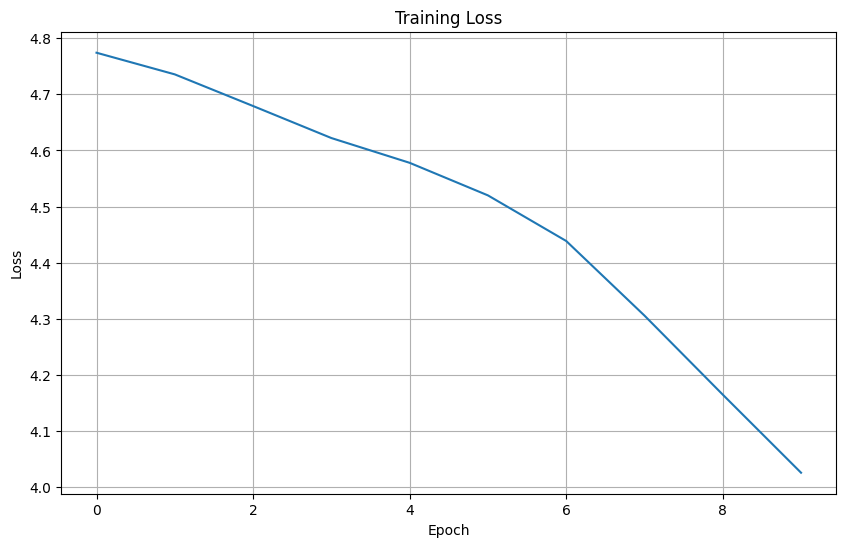

Source sequence: [93 44 12 54 61 64 71 16 61 53]
Target sequence: [99 53 61 16 71 64 61 54 12 44 93]
Predicted sequence: [99 12 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61]
Accuracy: 20.00%


In [3]:
class WarmupThenDecaySchedule:
    """
    Learning rate schedule with warmup and decay as described in the paper.
    """
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.current_step = 0

    def step(self):
        """
        Update learning rate and take an optimization step.
        """
        self.current_step += 1
        lr = self._get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        self.optimizer.step()

    def _get_lr(self):
        """
        Computes learning rate based on the formula in the paper.
        """
        arg1 = self.current_step ** -0.5
        arg2 = self.current_step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * min(arg1, arg2)

    def zero_grad(self):
        """
        Clear the gradients of all optimized parameters.
        """
        self.optimizer.zero_grad()


def train_transformer(model, train_dataloader, criterion, optimizer_schedule, n_epochs, device):
    """
    Train the transformer model.

    Args:
        model: Transformer model
        train_dataloader: DataLoader for training data
        criterion: Loss function
        optimizer_schedule: Learning rate scheduler
        n_epochs: Number of epochs
        device: Device to train on

    Returns:
        losses: List of training losses
    """
    model.train()
    losses = []

    for epoch in range(n_epochs):
        total_loss = 0

        for batch_idx, (inp, tar) in enumerate(train_dataloader):
            inp, tar = inp.to(device), tar.to(device)

            # Create target input and output
            tar_inp = tar[:, :-1]  # remove last token
            tar_real = tar[:, 1:]  # remove first token (start token)

            # Create masks
            enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

            # Forward pass
            optimizer_schedule.zero_grad()

            outputs = model(
                inp,
                tar_inp,
                enc_padding_mask,
                combined_mask,
                dec_padding_mask
            )

            # Calculate loss
            loss = criterion(
                outputs.contiguous().view(-1, outputs.size(-1)),
                tar_real.contiguous().view(-1)
            )

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer_schedule.step()

            # Track loss
            total_loss += loss.item()

            # Print progress
            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{n_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}')

        # Calculate average loss
        avg_loss = total_loss / len(train_dataloader)
        losses.append(avg_loss)

        print(f'Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss:.4f}')

    return losses



def greedy_decode(model, src, max_len, start_symbol, device):
    """
    Perform greedy decoding.

    Args:
        model: Trained transformer model
        src: Source sequence, shape [1, src_seq_len]
        max_len: Maximum length of the output sequence
        start_symbol: Start token id
        device: Device to run inference on

    Returns:
        decoded_sequence: Decoded sequence
    """
    model.eval()

    # Create encoder input
    src = src.to(device)

    # Encoder output
    enc_padding_mask = create_padding_mask(src)
    enc_output = model.encoder(src, enc_padding_mask)

    # Initialize decoder input with start token
    dec_input = torch.zeros(1, 1).fill_(start_symbol).type_as(src).to(device)

    # Decode one token at a time
    for i in range(max_len - 1):
        # Create masks
        dec_padding_mask = create_padding_mask(src)
        look_ahead_mask = create_look_ahead_mask(dec_input.size(1)).to(device)
        combined_mask = torch.max(
            create_padding_mask(dec_input),
            look_ahead_mask.unsqueeze(0)
        )

        # Decoder output
        dec_output = model.decoder(
            dec_input,
            enc_output,
            combined_mask,
            dec_padding_mask
        )

        # Final output and probabilities
        output = model.final_layer(dec_output)  # (1, seq_len, vocab_size)
        output = output[:, -1, :]  # (1, vocab_size)

        # Greedy decoding - pick the most probable token
        _, predicted = torch.max(output, dim=1)

        # Concatenate predicted token to decoder input
        dec_input = torch.cat(
            [dec_input, predicted.unsqueeze(1)],
            dim=1
        )

        # Break if end token is predicted
        if predicted.item() == 0:  # Assuming 0 is end token or padding
            break

    return dec_input.squeeze().cpu().numpy()



class SyntheticDataset(Dataset):
    """
    Simple synthetic dataset for sequence-to-sequence tasks.
    """
    def __init__(self, num_samples=1000, src_seq_len=10, tgt_seq_len=10,
                 src_vocab_size=100, tgt_vocab_size=100):
        self.num_samples = num_samples

        # Generate random source sequences
        self.src_data = torch.randint(
            1, src_vocab_size, (num_samples, src_seq_len)
        )

        # For simplicity, target is just the source sequence with digits reversed
        self.tgt_data = torch.flip(self.src_data, dims=[1])

        # Add start token (assuming tgt_vocab_size-1 is the start token)
        start_tokens = torch.full((num_samples, 1), tgt_vocab_size-1)
        self.tgt_data = torch.cat([start_tokens, self.tgt_data], dim=1)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.src_data[idx], self.tgt_data[idx]


# --- Model Hyperparameters ---
num_layers = 4
d_model = 128
num_heads = 8
d_ff = 512
input_vocab_size = 100
target_vocab_size = 100
dropout_rate = 0.1
batch_size = 32
num_epochs = 10

# --- Create Synthetic Dataset ---
train_dataset = SyntheticDataset(
    num_samples=1000,
    src_seq_len=10,
    tgt_seq_len=11,  # +1 for start token
    src_vocab_size=input_vocab_size,
    tgt_vocab_size=target_vocab_size
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# --- Initialize Model ---
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    dropout=dropout_rate
).to(device)

# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding token (0)
optimizer = optim.Adam(
    transformer.parameters(),
    lr=0,
    betas=(0.9, 0.98),
    eps=1e-9
)

# --- Learning Rate Schedule ---
lr_schedule = WarmupThenDecaySchedule(
    optimizer,
    d_model,
    warmup_steps=4000
)

# --- Train the Model ---
losses = train_transformer(
    transformer,
    train_dataloader,
    criterion,
    lr_schedule,
    num_epochs,
    device
)

# --- Plot Training Loss ---
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# --- Test Inference ---
def test_inference():
    # Select a random sample from the training set
    idx = np.random.randint(0, len(train_dataset))
    src, tgt = train_dataset[idx]

    # Prepare source tensor
    src = src.unsqueeze(0).to(device)  # Add batch dimension

    # Inference
    start_symbol = target_vocab_size - 1  # Start token
    output = greedy_decode(transformer, src, max_len=20, start_symbol=start_symbol, device=device)

    # Print results
    print(f"Source sequence: {src.squeeze().cpu().numpy()}")
    print(f"Target sequence: {tgt.numpy()}")
    print(f"Predicted sequence: {output}")

    # Check accuracy
    target_seq = tgt[1:].numpy()  # Remove start token
    pred_seq = output[1:]         # Remove start token

    # Truncate sequences to compare
    min_len = min(len(target_seq), len(pred_seq))
    target_seq = target_seq[:min_len]
    pred_seq = pred_seq[:min_len]

    accuracy = np.mean(target_seq == pred_seq) * 100
    print(f"Accuracy: {accuracy:.2f}%")

test_inference()